In [3]:
from tensorflow.keras import layers
import numpy as np
import tensorflow as tf
latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = tf.keras.Input(shape=(latent_dim,))


x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)


x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)


x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)


x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
out_g = layers.Conv2D(channels, 7, activation='sigmoid', padding='same')(x)


generator = tf.keras.models.Model(generator_input, out_g)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       104883

In [9]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)

out_d = layers.Dense(1, activation='sigmoid')(x)

discriminator = tf.keras.models.Model(discriminator_input, out_d)
discriminator.summary()

discriminator_optimizer = tf.keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 6, 6, 128)         0   

In [10]:
gan_input = tf.keras.Input(shape=(latent_dim,))
img_f=generator(gan_input)
discriminator.trainable = False

gan_output = discriminator(img_f)
gan = tf.keras.models.Model(gan_input, gan_output)

gan_optimizer = tf.keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')
gan.summary()


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32)                0         
_________________________________________________________________
model_4 (Model)              (None, 32, 32, 3)         6264579   
_________________________________________________________________
model_5 (Model)              (None, 1)                 790913    
Total params: 7,055,492
Trainable params: 6,264,579
Non-trainable params: 790,913
_________________________________________________________________


In [9]:
import os
from tensorflow.keras.preprocessing import image

# Load CIFAR10 data
(x_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()
print(x_train.shape)
print(y_train.shape)
y1=y_train.flatten()
y2=np.squeeze(y_train)
print(y1.shape)
print(y2.shape)
print(y1[:3])
print(y2[:3])
# Select frog images (class 6)
x_train = x_train[y_train.flatten() == 6]

x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

print(x_train.shape)

(50000, 32, 32, 3)
(50000, 1)
(50000,)
(50000,)
[6 9 9]
[6 9 9]
(5000, 32, 32, 3)


In [12]:

iterations = 8000
batch_size = 20

start = 0
for step in range(iterations):
    
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    generated_images = generator.predict(random_latent_vectors)

    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([real_images, generated_images])

   
    y= np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
   
    y += 0.05 * np.random.random(y.shape)

    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images,y)

    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Assemble labels that say "all real images"
    misleading_targets = np.ones((batch_size, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # Occasionally save / plot
    if (step+1) % 1000 == 0:
        # Print metrics
        print('discriminator loss at step %s: %s' % ((step+1), d_loss))
        print('adversarial loss at step %s: %s' % ((step+1), a_loss))       

C:\Users\ysp\anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\ysp\anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at step 1000: 0.6959399
adversarial loss at step 1000: 0.65253323
discriminator loss at step 2000: 0.7133257
adversarial loss at step 2000: 0.64863485
discriminator loss at step 3000: 0.6849048
adversarial loss at step 3000: 0.65296715
discriminator loss at step 4000: 0.6989826
adversarial loss at step 4000: 0.6304122
discriminator loss at step 5000: 0.68881655
adversarial loss at step 5000: 0.6347566
discriminator loss at step 6000: 0.69903404
adversarial loss at step 6000: 0.649267
discriminator loss at step 7000: 0.6809589
adversarial loss at step 7000: 0.6573416
discriminator loss at step 8000: 0.6914166
adversarial loss at step 8000: 0.6671444


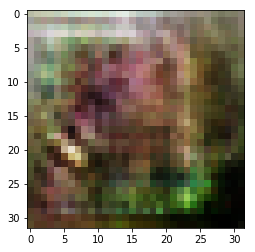

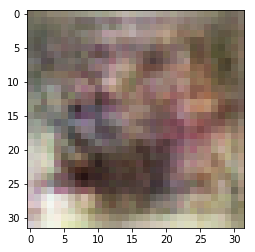

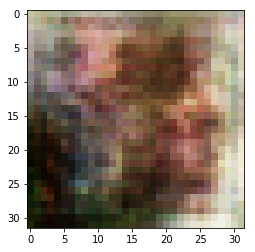

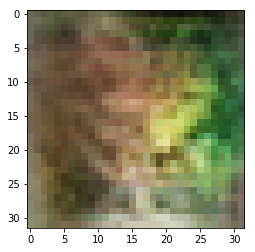

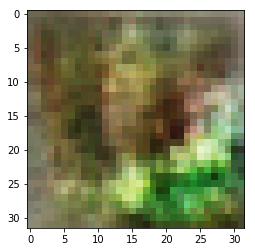

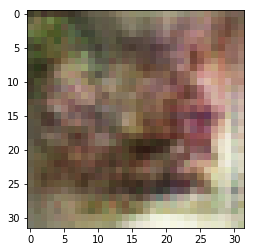

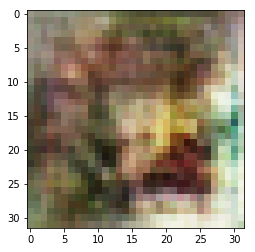

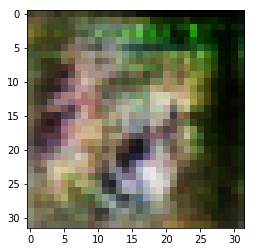

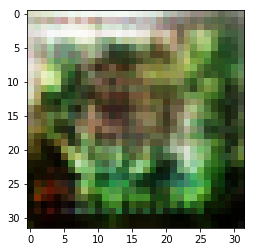

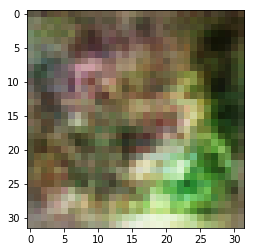

In [13]:
import matplotlib.pyplot as plt

random_latent_vectors = np.random.normal(size=(10, latent_dim))

generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()